# pyVDJ for fetal BM B cells

This tutorial is for pyVDJ v0.1.1. The package is available here: https://github.com/veghp/pyVDJ

# Import packages

In [1]:
#import warnings
#from matplotlib.axes._axes import _log as matplotlib_axes_logger
#matplotlib_axes_logger.setLevel('ERROR')
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import upsetplot 
import pyvdj

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load B cell data

In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig3a_bcell_dr_20210115.h5ad")

In [4]:
adata.shape

(28583, 33712)

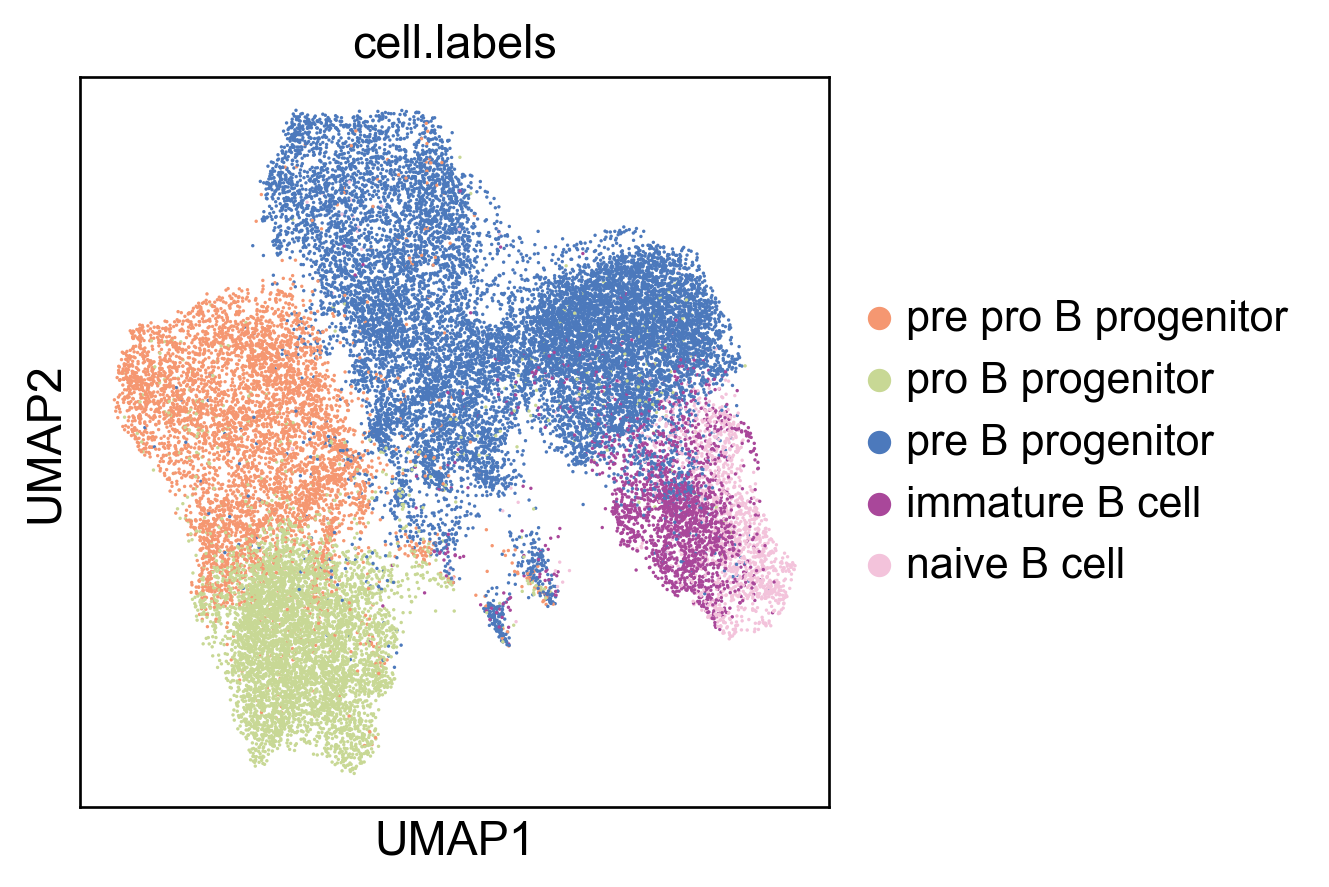

In [5]:
sc.pl.umap(adata, color=['cell.labels'])

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
pre pro B progenitor     5427
pro B progenitor         5528
pre B progenitor        14229
immature B cell          1988
naive B cell             1411
dtype: int64

# Subset to samples which we have VDJ data for

In [7]:
adata = adata[adata.obs['orig.ident'].isin(['F50', 'F51'])].copy()

In [8]:
adata.shape

(8298, 33712)

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
pre pro B progenitor    1646
pro B progenitor        2954
pre B progenitor        2825
immature B cell          334
naive B cell             539
dtype: int64

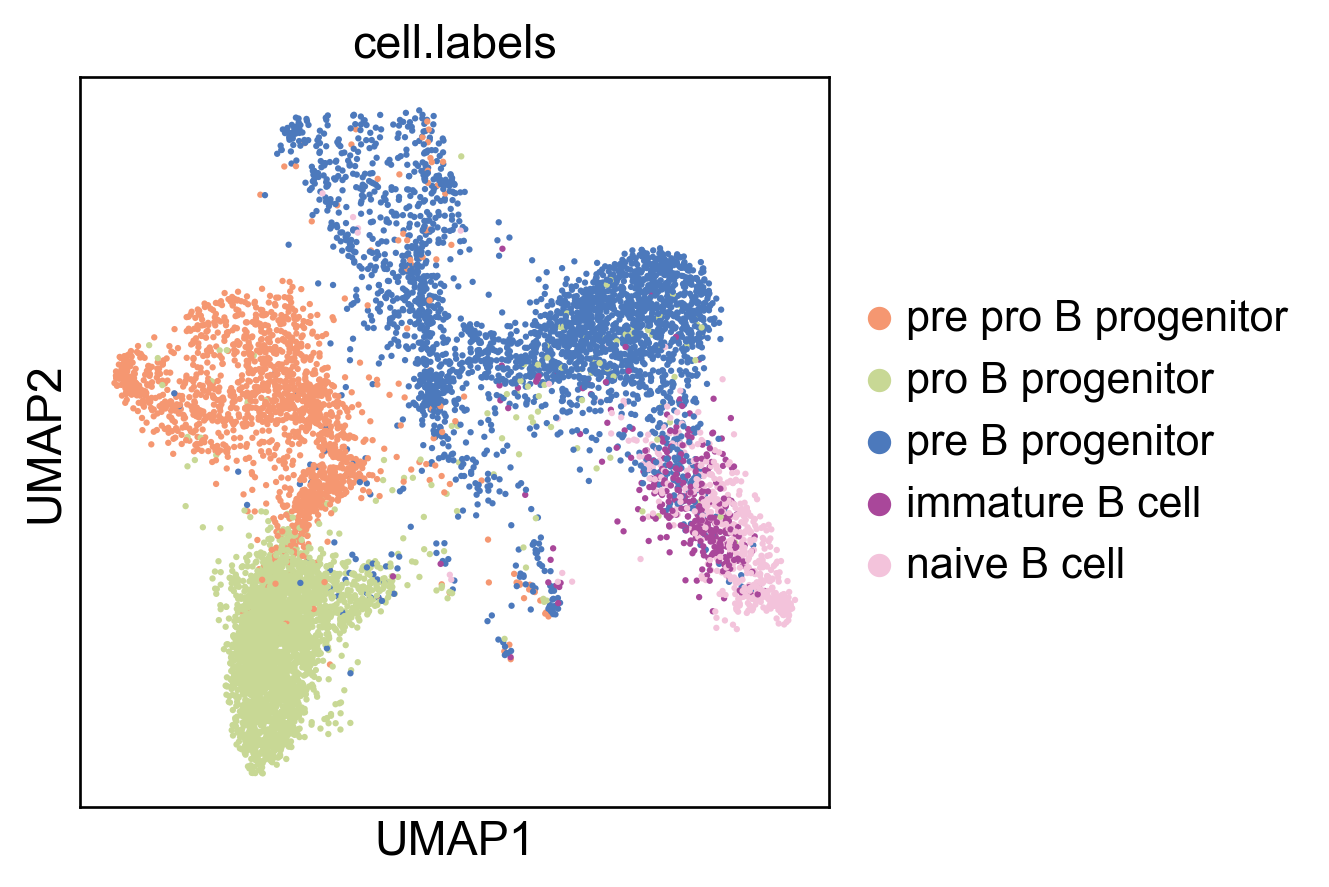

In [10]:
sc.pl.umap(adata, color='cell.labels', use_raw=False)

# Load VDJ data

### Load the  VDJ data in (using a manifest to match to their GEX pair)

To load in the VDJ data, we construct filepaths and a dictionary linking files to sample names. The easiest way is to prepare a manifest that lists the GEX sample names next to the V(D)J 10x directory names in a csv file.

We have seven lanes of TCR enriched VDJ data and five lanes of BCR enriched VDJ data 

In [11]:
# set the path for the manifest/vdj_data_files and the columns for the T and B cell enrichment
adata_GEX_lanes_name = 'lanes'

manifest = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/bm/figs/counts/10x_lane_info.csv")
manifest_GEX_lanes_col = 'SANGER.SAMPLE.IDs'
manifest_B_cell_enrichment_col = 'B_cell_enrichment'
manifest_T_cell_enrichment_col = 'T_cell_enrichment'

vdj_data_path = '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/'
vdj_figs_path = '/Users/b8058304/Documents/PhD_work/Coding/bm/figs/vdj/'

In [12]:
manifest = manifest[manifest[manifest_GEX_lanes_col].isin(adata.obs[adata_GEX_lanes_name].unique())]  # keep the ones in adata
manifest[:5]

SANGER.SAMPLE.IDs     SAMPLE.NAME       Organ Sequencing  Passed AnnatomicalPart T_cell_enrichment B_cell_enrichment
18    FCAImmP7803018  F50_BM_CD45N_1  boneMarrow       5GEX    True         unknown               NaN               NaN
19    FCAImmP7803019  F50_BM_CD45N_2  boneMarrow       5GEX    True         unknown               NaN               NaN
20    FCAImmP7803016  F50_BM_CD45P_5  boneMarrow       5GEX    True         unknown    FCAImmP7812643    FCAImmP7812647
21    FCAImmP7803017  F50_BM_CD45P_6  boneMarrow       5GEX    True         unknown    FCAImmP7812644    FCAImmP7812648
22    FCAImmP7803031  F51_BM_CD45N_1  boneMarrow       5GEX    True         unknown               NaN               NaN

In [13]:
manifest = manifest[manifest[manifest_B_cell_enrichment_col].notnull()]  # can remove samples which have no VDJ (we have VDJ for all GEX)
# Construct paths to VDJ csv files:
paths = vdj_data_path + manifest[manifest_B_cell_enrichment_col] + '/filtered_contig_annotations.csv'
# Construct paths to VDJ csv files:
samples = dict(zip(paths, manifest[manifest_GEX_lanes_col]))
samples

{'/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812647/filtered_contig_annotations.csv': 'FCAImmP7803016',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812648/filtered_contig_annotations.csv': 'FCAImmP7803017',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812658/filtered_contig_annotations.csv': 'FCAImmP7803028',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812659/filtered_contig_annotations.csv': 'FCAImmP7803029',
 '/Users/b8058304/Documents/PhD_work/Coding/bm/data/vdj_data/FCAImmP7812660/filtered_contig_annotations.csv': 'FCAImmP7803030'}

##### Prepare metadata column in adata object

The AnnData object must contain a metadata column (e.g. `adata.obs['vdj_obs']`) of the following format: `cellbarcode + '_' + lane`. This can be constructed from the cell barcodes and lane names (provided that we have sample annotation):

We then read V(D)J data into the AnnData object and create annotations. Note that values in the `filtered_contig_annotations.csv` files cannot be directly added as annotations, because one cell may have 0 to n values per entry. It will be stored in `adata.uns` and annotation will be generated separately.

Also note that the nomenclature used for the barcodes in `adata.obs['vdj_obs']` slot must match the nomenclature used for barcodes stored in `adata.uns['pyvdj']['df']['barcode']` later on in this notebook

In [14]:
cellnames = adata.obs_names
cellbarcode = cellnames.str.split("_").str[5:6].str.join("-") # cell barcode part + '-1'
adata.obs['vdj_obs'] = cellbarcode.astype(str) + "-1_" + adata.obs['lanes'].astype(str)

In [15]:
adata.obs['vdj_obs']

index
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AACCATGGTCTAGAGG    AACCATGGTCTAGAGG-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ACCGTAAGTCATACTG    ACCGTAAGTCATACTG-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGTCTTTTCCCTAATT    AGTCTTTTCCCTAATT-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CGTCACTGTTCCACGG    CGTCACTGTTCCACGG-1_FCAImmP7803016
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CGTGTCTAGGCCGAAT    CGTGTCTAGGCCGAAT-1_FCAImmP7803016
                                                                           ...                
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_GGATTACGTCTGCAAT    GGATTACGTCTGCAAT-1_FCAImmP7803033
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_GTTAAGCAGGACAGAA    GTTAAGCAGGACAGAA-1_FCAImmP7803033
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_TACGGGCCAGCCTTGG    TACGGGCCAGCCTTGG-1_FCAImmP7803033
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_TAGACCACACCGATAT    TAGACCACACCGATAT-1_FCAImmP7803033
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_TGA

This loaded 10x V(D)J sequencing data (i.e. filtered_contig_annotations.csv files) into adata.uns['pyvdj']. `obs_col` specifies the annotation column for cellnames, as prepared above. For Cell Ranger version 3, set the parameter to 3.
For definitions of some words (clone, clonotype etc) used in the next section, see https://github.com/veghp/pyVDJ.

In [16]:
adata = pyvdj.load_vdj(samples, adata, obs_col='vdj_obs', cellranger=2)

In [17]:
len(adata.uns["pyvdj"]["df"]["clonotype_meta"].unique())

6450

# Add in productivity and clonality metadata

This generates annotation in `adata.obs`. Now we can plot V(D)J properties:

This will show whether we have VDJ data for a cell we have captured in the GEX. It will also show if that cell is a clone (a cell whose TCR is identical to another cell, within the same individual (donor, organism)) and if it is productive (produces a TCR/BCR at protein level)

In [18]:
adata = pyvdj.add_obs(adata, obs=['clonotype', 'is_clone'])

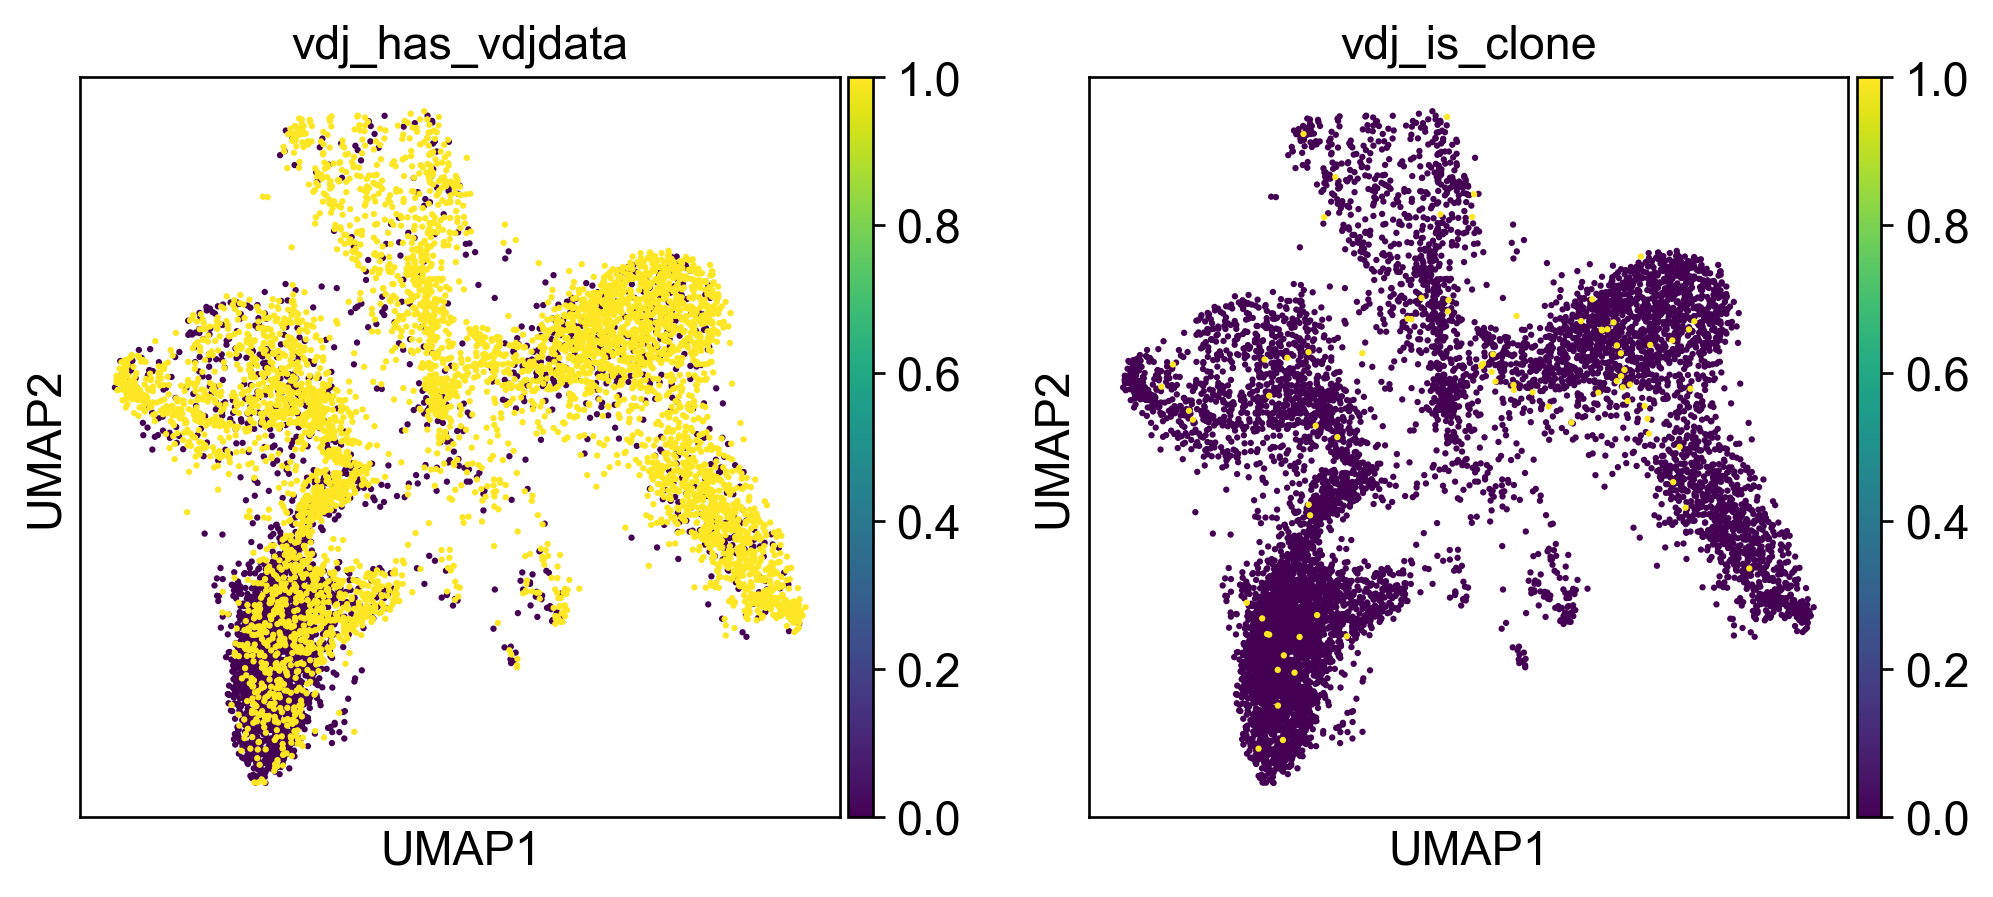

In [19]:
# When running on BCR data, we see the clones are restricted to the B lymphoid cells
sc.pl.umap(adata, color=['vdj_has_vdjdata', 'vdj_is_clone'])

In [20]:
allcell = len(adata.obs['vdj_has_vdjdata'])
vdjcell = sum(adata.obs['vdj_has_vdjdata'])
print('We have %d cells with VDJ data, out of %d cells.' % (vdjcell, allcell))

We have 5052 cells with VDJ data, out of 8298 cells.


In [21]:
cell_numbers = adata.obs.groupby(["lanes", "vdj_has_vdjdata"]).apply(len)
cell_numbers

lanes           vdj_has_vdjdata
FCAImmP7803016  False               931
                True                303
FCAImmP7803017  False               314
                True                910
FCAImmP7803018  False                 5
FCAImmP7803019  False                 1
FCAImmP7803028  False               699
                True               1328
FCAImmP7803029  False               623
                True               1243
FCAImmP7803030  False               635
                True               1268
FCAImmP7803031  False                13
FCAImmP7803032  False                12
FCAImmP7803033  False                13
dtype: int64

In [22]:
adata.obs['vdj_is_clone'].dtype

dtype('bool')

In [23]:
df = pd.DataFrame({'count' : adata.obs.groupby(["vdj_is_clone", "cell.labels", "orig.ident"]).size()}).reset_index()
clone_df = df[df["vdj_is_clone"]==True]
clone_df

vdj_is_clone           cell.labels orig.ident  count
10          True  pre pro B progenitor        F50      1
11          True  pre pro B progenitor        F51      9
12          True      pro B progenitor        F50      5
13          True      pro B progenitor        F51      9
14          True      pre B progenitor        F50      5
15          True      pre B progenitor        F51     40
16          True       immature B cell        F50      0
17          True       immature B cell        F51      8
18          True          naive B cell        F50      0
19          True          naive B cell        F51      0

In [24]:
df = pd.DataFrame({'count' : adata.obs.groupby(["vdj_is_clone", "cell.labels", "orig.ident", "vdj_clonotype"]).size()}).reset_index()
clone_df = df[df["vdj_is_clone"]==True]
clone_df

vdj_is_clone           cell.labels orig.ident                                     vdj_clonotype  count
50110           True  pre pro B progenitor        F50  AAACCTGAGCTTATCG-1_FCAImmP7803030_FCAImmP7803030      0
50111           True  pre pro B progenitor        F50  AAACCTGAGCTTCGCG-1_FCAImmP7803028_FCAImmP7803028      0
50112           True  pre pro B progenitor        F50  AAACCTGCAACGCACC-1_FCAImmP7803029_FCAImmP7803029      0
50113           True  pre pro B progenitor        F50  AAACCTGCAATCTGCA-1_FCAImmP7803028_FCAImmP7803028      0
50114           True  pre pro B progenitor        F50  AAACCTGCAGGACGTA-1_FCAImmP7803029_FCAImmP7803029      0
...              ...                   ...        ...                                               ...    ...
100215          True          naive B cell        F51                        clonotype99_FCAImmP7803030      0
100216          True          naive B cell        F51                         clonotype9_FCAImmP7803017      0
100217          True          naive B cell        F51                         clonotype9_FCAImmP7803028      0
100218          True          naive B cell        F51                         clonotype9_FCAImmP7803029      0
100219          True          naive B cell        F51                         clonotype9_FCAImmP7803030      0

[50110 rows x 5 columns]

In [25]:
is_clone = sum(adata.obs['vdj_is_clone'])
print('We have %d cells with clones, out of %d cells.' % (is_clone, allcell))

We have 77 cells with clones, out of 8298 cells.


In [26]:
# productivity = if all productive, all chains (poss 1 - 4) productive. protein coming from the rna.
adata = pyvdj.add_obs(adata, obs=['all_productive', 'any_productive'])
adata.uns['vdj_any_productive_colors'] = ['#1f77b4', '#ececec', '#ff0000']
adata.obs['vdj_any_productive'] = adata.obs['vdj_any_productive'].replace(["False", "None", "True"], ["no_productive_chains", "no_vdj_data", "some_productive_chains"])

# Visualise productivity of chains by celltype (save UMAPs and as csv)

In [27]:
adata.obs.groupby(['vdj_any_productive']).apply(len)

vdj_any_productive
False    1825
True     3227
dtype: int64

In [28]:
cell_numbers = adata.obs.groupby(["cell.labels", "vdj_any_productive"]).apply(len)
cell_numbers

cell.labels           vdj_any_productive
pre pro B progenitor  False                 1116
                      True                    82
pro B progenitor      False                  519
                      True                   271
pre B progenitor      False                  143
                      True                  2165
immature B cell       False                   27
                      True                   245
naive B cell          False                   20
                      True                   464
dtype: int64

... storing 'vdj_all_productive' as categorical
... storing 'vdj_any_productive' as categorical


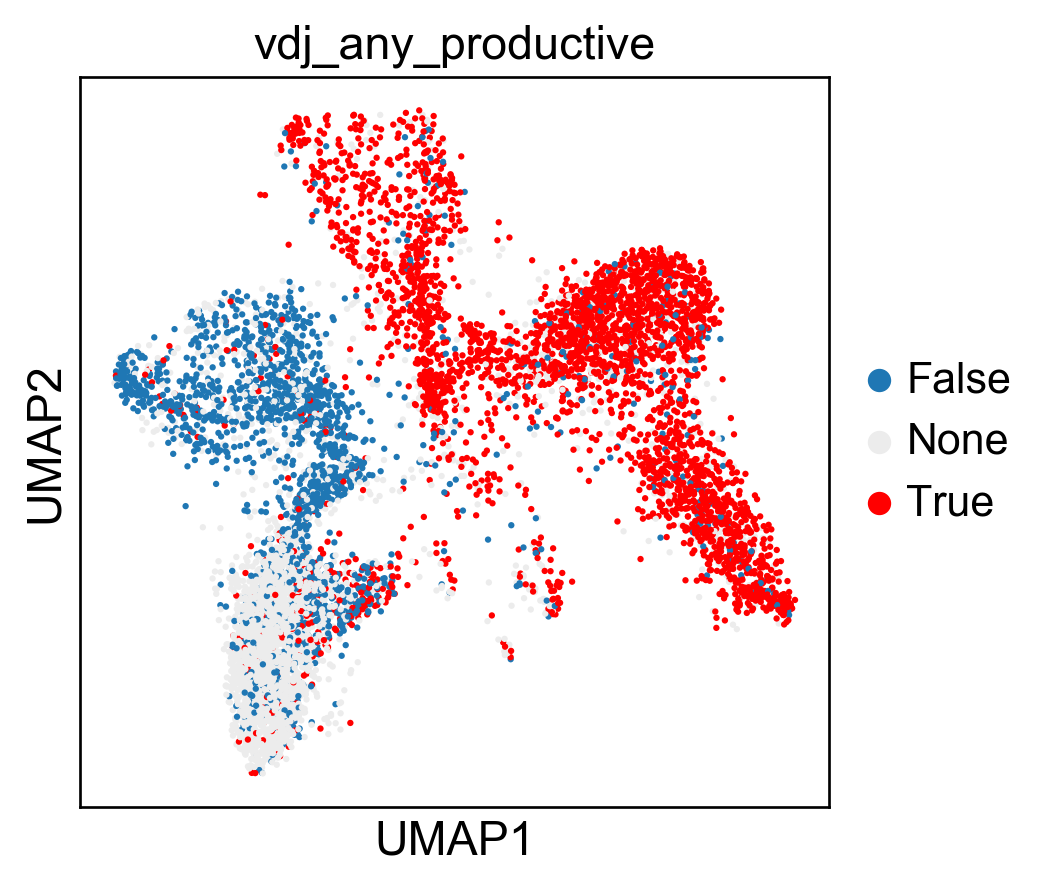

In [29]:
sc.pl.umap(adata, color=['vdj_any_productive'], save="bcell_umap_productive_20210115.pdf")

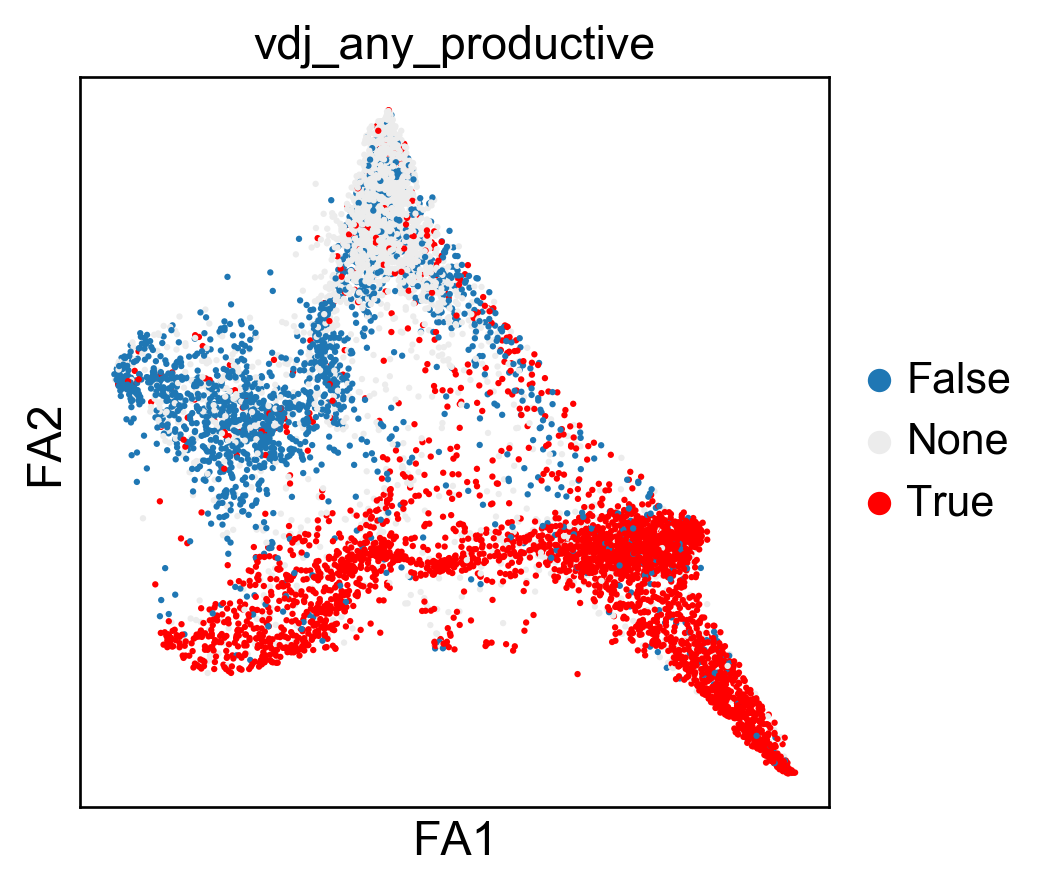

In [30]:
sc.pl.draw_graph(adata, color=['vdj_any_productive'], save="bcell_fdg_productive_20210115.pdf", layout="fa")

In [31]:
cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_any_productive"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/vdj_productivity_20210115.csv")
cell_numbers

cell.labels           orig.ident  vdj_any_productive
pre pro B progenitor  F50         False                  164
                                  None                   185
                                  True                    29
                      F51         False                  952
                                  None                   263
                                  True                    53
pro B progenitor      F50         False                  119
                                  None                   482
                                  True                    96
                      F51         False                  400
                                  None                  1682
                                  True                   175
pre B progenitor      F50         False                   64
                                  None                   472
                                  True                   568
                      F51       

# Add in type of chain

In [32]:
# The following command adds one boolean metadata column (in adata.obs) for each type of chain found in the V(D)J data:
adata = pyvdj.add_obs(adata, obs=['chains'])

IGL
TRB
IGH
TRA
Multi
IGK
None
TRG
TRD


In [33]:
adata.obs[:3]

cell.labels doublets         fetal.ids  gender is_doublet is_doublet_poptrim is_doublet_wolock           lanes   nGene     nUMI orig.ident  percent.mito processing.type  scrublet_cluster_score  scrublet_score sequencing.type sort.ids     april_cell.labels  cell.labels_20200708  cell.labels_20200713  cell.labels_20200718 nk_meta mito.threshold   S_score  G2M_score phase phase_combined  S/G2M_score_combined bcell_state             cell.labels_state __is_in_cluster__                            vdj_obs  vdj_has_vdjdata                                     vdj_clonotype  vdj_clone_count  vdj_is_clone vdj_all_productive vdj_any_productive vdj_chain_IGL vdj_chain_TRB vdj_chain_IGH vdj_chain_TRA vdj_chain_Multi vdj_chain_IGK vdj_chain_None vdj_chain_TRG vdj_chain_TRD
index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AACCAT...  pre pro B progenitor  Doublet  F50_female_15PCW  female      False              False             False  FCAImmP7803016  3041.0   9580.0        F50      0.024113              IG                0.075028        0.124797            5GEX    CD45+  Pre pro B progenitor  Pre pro B progenitor  Pre pro B progenitor  pre pro B progenitor     nan           pass  0.400563   0.174332     S          G2M/S              0.287448     cycling  pre pro B progenitor_cycling             False  AACCATGGTCTAGAGG-1_FCAImmP7803016             True  AACCATGGTCTAGAGG-1_FCAImmP7803016_FCAImmP7803016                1         False              False              False          True         False         False          True            True         False          False         False         False
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ACCGTA...  pre pro B progenitor  Doublet  F50_female_15PCW  female      False              False             False  FCAImmP7803016  3942.0  14677.0        F50      0.030320              IG                0.063922        0.071101            5GEX    CD45+  Pre pro B progenitor  Pre pro B progenitor  Pre pro B progenitor  pre pro B progenitor     nan           pass  0.153210   0.759597   G2M          G2M/S              0.456404     cycling  pre pro B progenitor_cycling             False  ACCGTAAGTCATACTG-1_FCAImmP7803016             True  ACCGTAAGTCATACTG-1_FCAImmP7803016_FCAImmP7803016                1         False              False              False         False         False          True         False            True         False          False         False         False
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGTCTT...  pre pro B progenitor  Doublet  F50_female_15PCW  female      False              False             False  FCAImmP7803016  3546.0  15486.0        F50      0.026024              IG                0.063922        0.063922            5GEX    CD45+  Pre pro B progenitor  Pre pro B progenitor  Pre pro B progenitor  pre pro B progenitor     nan           pass  0.231900   0.603262   G2M          G2M/S              0.417581     cycling  pre pro B progenitor_cycling             False  AGTCTTTTCCCTAATT-1_FCAImmP7803016            False                                               NaN                0         False               None               None       No_data       No_data       No_dat

In [34]:
del adata.obs["vdj_chain_TRB"]
del adata.obs["vdj_chain_TRA"]
del adata.obs["vdj_chain_TRG"]
del adata.obs["vdj_chain_TRD"]

In [35]:
adata.obs["ig_chains"] = adata.obs["vdj_chain_IGL"].astype(str) + '_' + adata.obs["vdj_chain_IGH"].astype(str) + '_' + adata.obs["vdj_chain_IGK"].astype(str)
adata.obs["vdj_ig_chains"] = adata.obs["ig_chains"] 

chain_list = ["False_False_False", "False_False_True", "False_True_False", "False_True_True", "No_data_No_data_No_data", "True_False_False", "True_False_True", "True_True_False", "True_True_True"]
chain_list_new = ["no_chains", "IGK", "IGH", "IGH+IGK", "no_vdj_data", "IGL", "IGL+IGK", "IGH+IGL", "IGH+IGL+IGK"]
adata.obs["vdj_ig_chains"] = adata.obs["vdj_ig_chains"].replace(chain_list, chain_list_new)

chain_list = ["no_chains", "IGK", "IGH", "IGH+IGK", "no_vdj_data", "IGL", "IGL+IGK", "IGH+IGL", "IGH+IGL+IGK"]
chain_list_new = ["no_chains", "light_chain", "heavy_chain", "heavy_chain_plus_light", "no_vdj_data", "light_chain", "light_chain", "heavy_chain_plus_light", "heavy_chain_plus_light"]
adata.obs["vdj_ig_chains"] = adata.obs["vdj_ig_chains"].replace(chain_list, chain_list_new)

adata.obs["vdj_ig_chains"] = adata.obs["vdj_ig_chains"].astype("category")
adata.obs["vdj_ig_chains"] = adata.obs["vdj_ig_chains"].cat.reorder_categories(['heavy_chain_plus_light',
 'heavy_chain', 'light_chain', 'no_chains',  'no_vdj_data'])

In [36]:
new = adata[~adata.obs['vdj_ig_chains'].isin(['no_vdj_data'])].copy()
new.uns['vdj_ig_chains_colors'] = ['#800080', '#00bce1', '#ff2929', '#c1c1c1', '#ffffff', '#00d200', '#00d6ff', '#9c9c9c', '#ececec']

# Visualise type of chains by celltype (save UMAPs and as csv)

... storing 'vdj_chain_IGL' as categorical
... storing 'vdj_chain_IGH' as categorical
... storing 'vdj_chain_Multi' as categorical
... storing 'vdj_chain_IGK' as categorical
... storing 'vdj_chain_None' as categorical
... storing 'ig_chains' as categorical


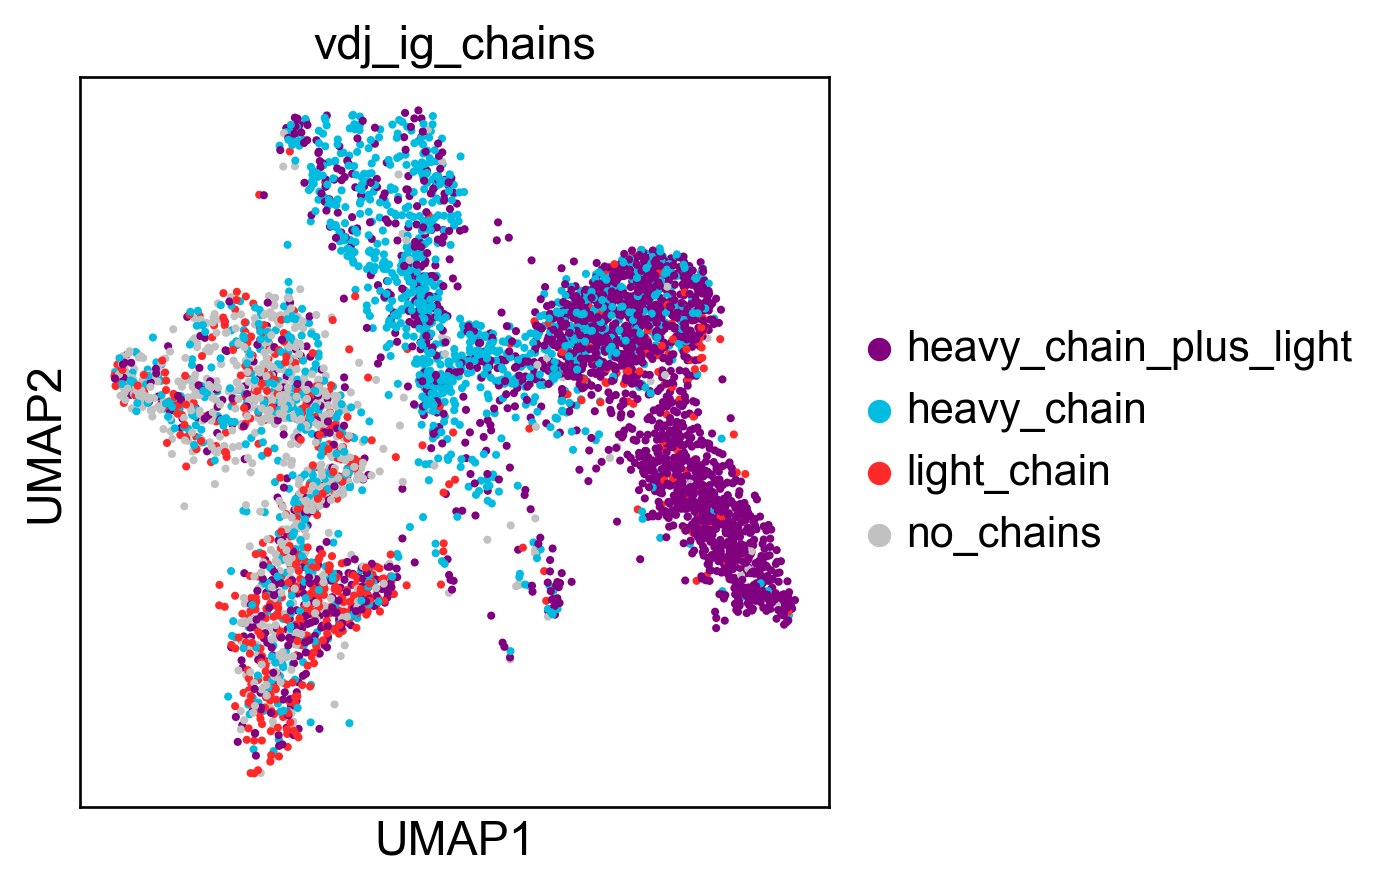

In [37]:
sc.pl.umap(new, color='vdj_ig_chains', save="bcell_chains_20210115.pdf")

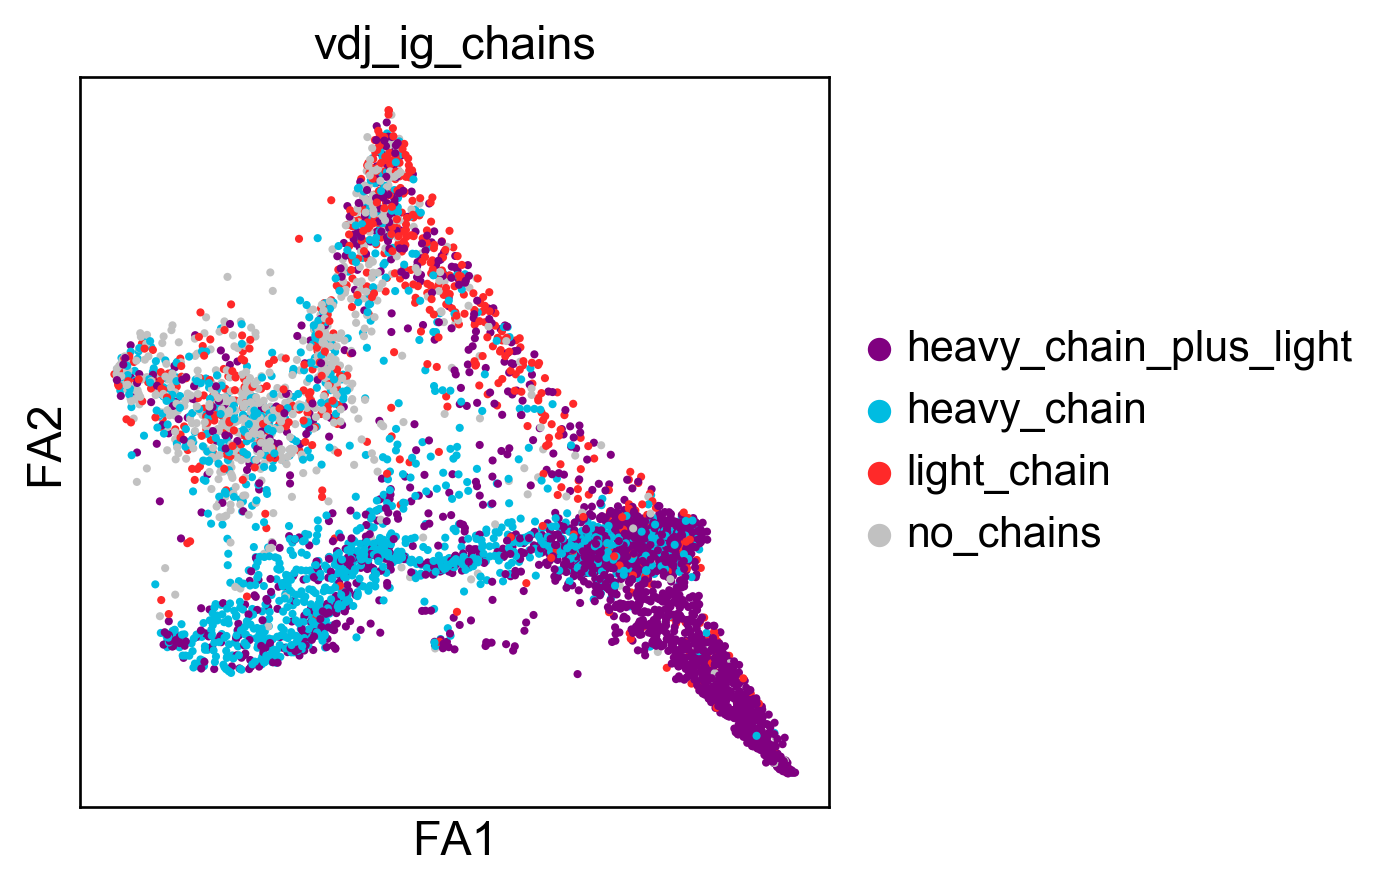

In [38]:
sc.pl.draw_graph(new, color=['vdj_ig_chains'], save="bcell_fdg_chains_20210115.pdf", layout="fa")

In [39]:
cell_numbers = adata.obs.groupby(["cell.labels", "vdj_ig_chains"]).apply(len)
cell_numbers

cell.labels           vdj_ig_chains         
pre pro B progenitor  heavy_chain_plus_light     132
                      heavy_chain                317
                      light_chain                211
                      no_chains                  538
                      no_vdj_data                448
pro B progenitor      heavy_chain_plus_light     221
                      heavy_chain                133
                      light_chain                286
                      no_chains                  150
                      no_vdj_data               2164
pre B progenitor      heavy_chain_plus_light    1209
                      heavy_chain                971
                      light_chain                 97
                      no_chains                   31
                      no_vdj_data                517
immature B cell       heavy_chain_plus_light     229
                      heavy_chain                  9
                      light_chain                 31
 

In [40]:
cell_numbers = adata.obs.groupby(["cell.labels", "orig.ident", "vdj_ig_chains"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/vdj_chains_20210115.csv")
cell_numbers[:20]

cell.labels           orig.ident  vdj_ig_chains         
pre pro B progenitor  F50         heavy_chain_plus_light      33
                                  heavy_chain                 54
                                  light_chain                 47
                                  no_chains                   59
                                  no_vdj_data                185
                      F51         heavy_chain_plus_light      99
                                  heavy_chain                263
                                  light_chain                164
                                  no_chains                  479
                                  no_vdj_data                263
pro B progenitor      F50         heavy_chain_plus_light      60
                                  heavy_chain                 39
                                  light_chain                 83
                                  no_chains                   33
                                 

In [41]:
cell_numbers = adata.obs.groupby(["vdj_any_productive", "cell.labels", "orig.ident", "vdj_ig_chains"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/vdj_chains_productive_20210115.csv")
cell_numbers[:20]

vdj_any_productive  cell.labels           orig.ident  vdj_ig_chains         
False               pre pro B progenitor  F50         heavy_chain_plus_light     18
                                                      heavy_chain                48
                                                      light_chain                39
                                                      no_chains                  59
                                          F51         heavy_chain_plus_light     78
                                                      heavy_chain               246
                                                      light_chain               149
                                                      no_chains                 479
                    pro B progenitor      F50         heavy_chain_plus_light     17
                                                      heavy_chain                12
                                                      light_chain                58

# Add in clonotype info

We can flag which cells are members of a clonotype with a number of clones that is greater than or equal to _n_ clones:

In [42]:
adata = pyvdj.add_gt_n(adata, n=2)

... storing 'vdj_chain_IGL' as categorical
... storing 'vdj_chain_IGH' as categorical
... storing 'vdj_chain_Multi' as categorical
... storing 'vdj_chain_IGK' as categorical
... storing 'vdj_chain_None' as categorical
... storing 'ig_chains' as categorical
... storing 'vdj_clonotype_n_2' as categorical


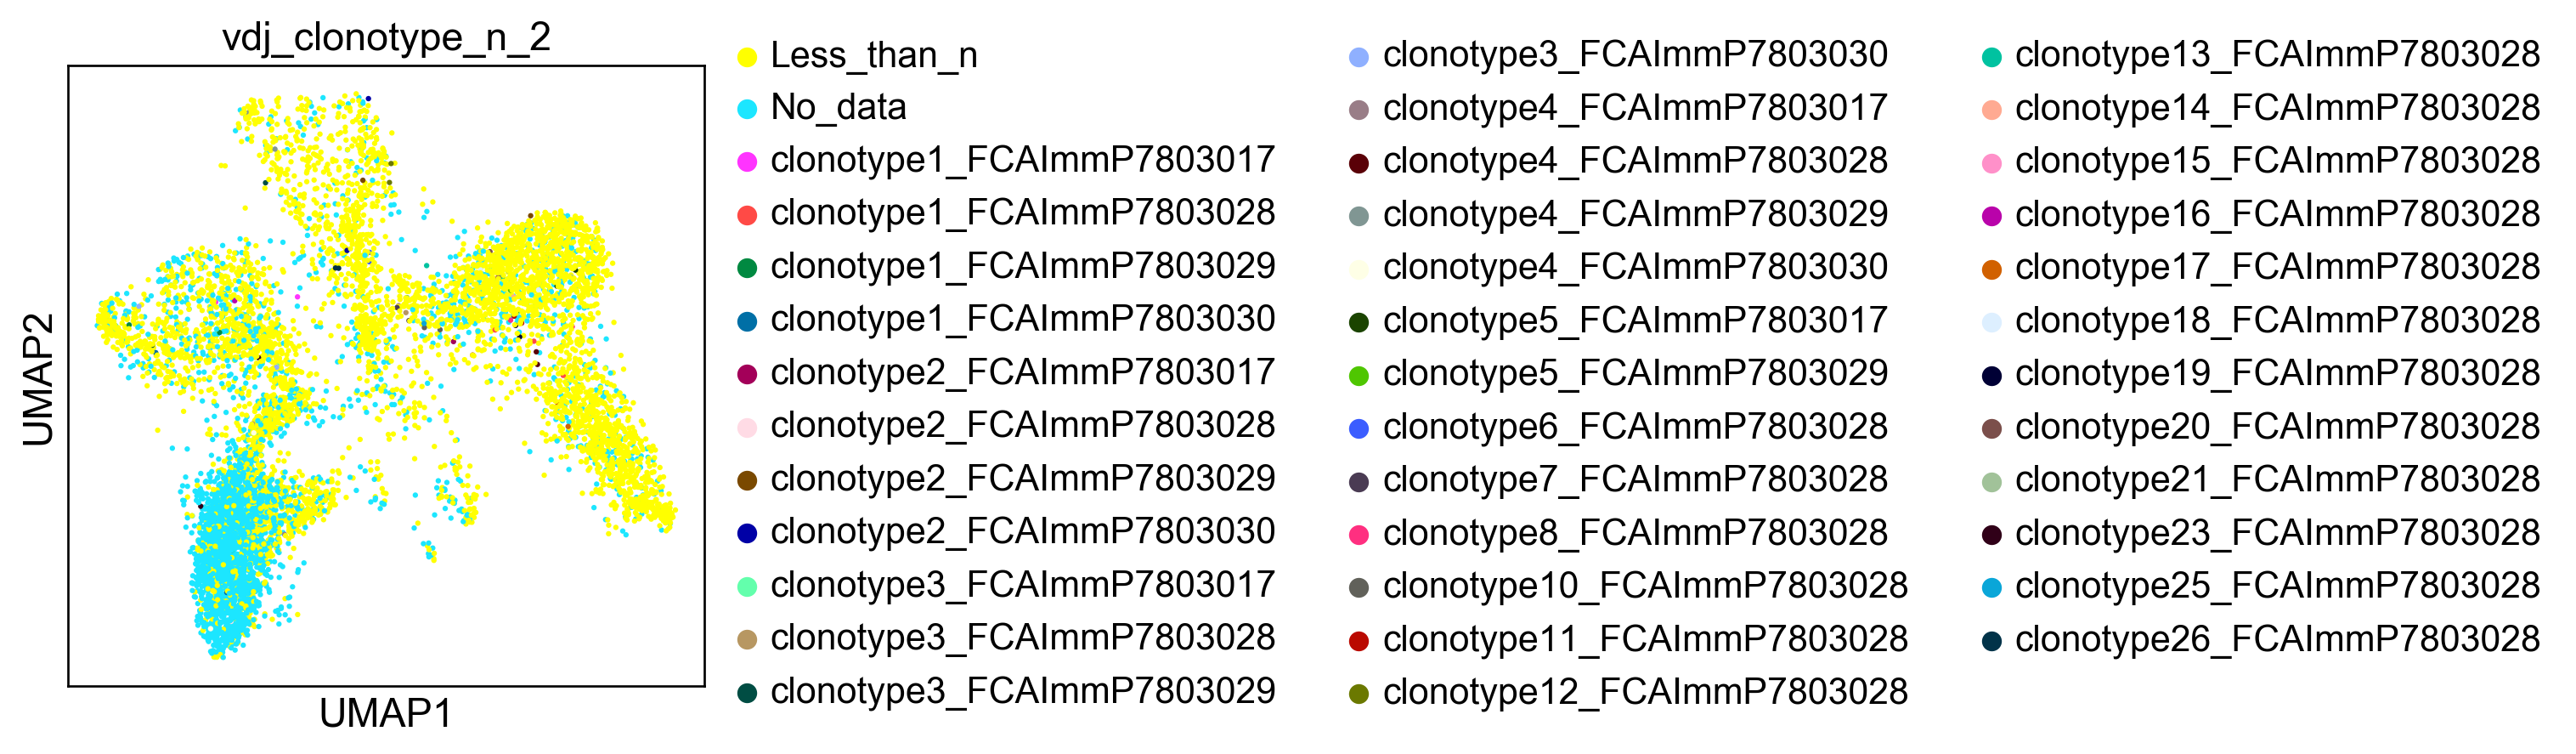

In [43]:
sc.pl.umap(adata, color='vdj_clonotype_n_2')

In [44]:
## Import path info and see which path the cells with clonotypes sit on
total_data = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig3a_bcell_dr_20210115.h5ad")

In [45]:
cell_numbers = total_data.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
pre pro B progenitor     5427
pro B progenitor         5528
pre B progenitor        14229
immature B cell          1988
naive B cell             1411
dtype: int64

In [46]:
total_data.obs["S/G2M_score_combined"].mean()

0.12705286

In [47]:
a = pd.DataFrame(total_data.obs["S/G2M_score_combined"])

total_data.obs["bcell_state"] = pd.cut(a["S/G2M_score_combined"],
                 [-1, 0.11, np.inf],
                 labels=['not_cycling','cycling'])

cell_numbers = total_data.obs.groupby(["bcell_state"]).apply(len)
cell_numbers

bcell_state
not_cycling    16816
cycling        11767
dtype: int64

... storing 'cell.labels_state' as categorical


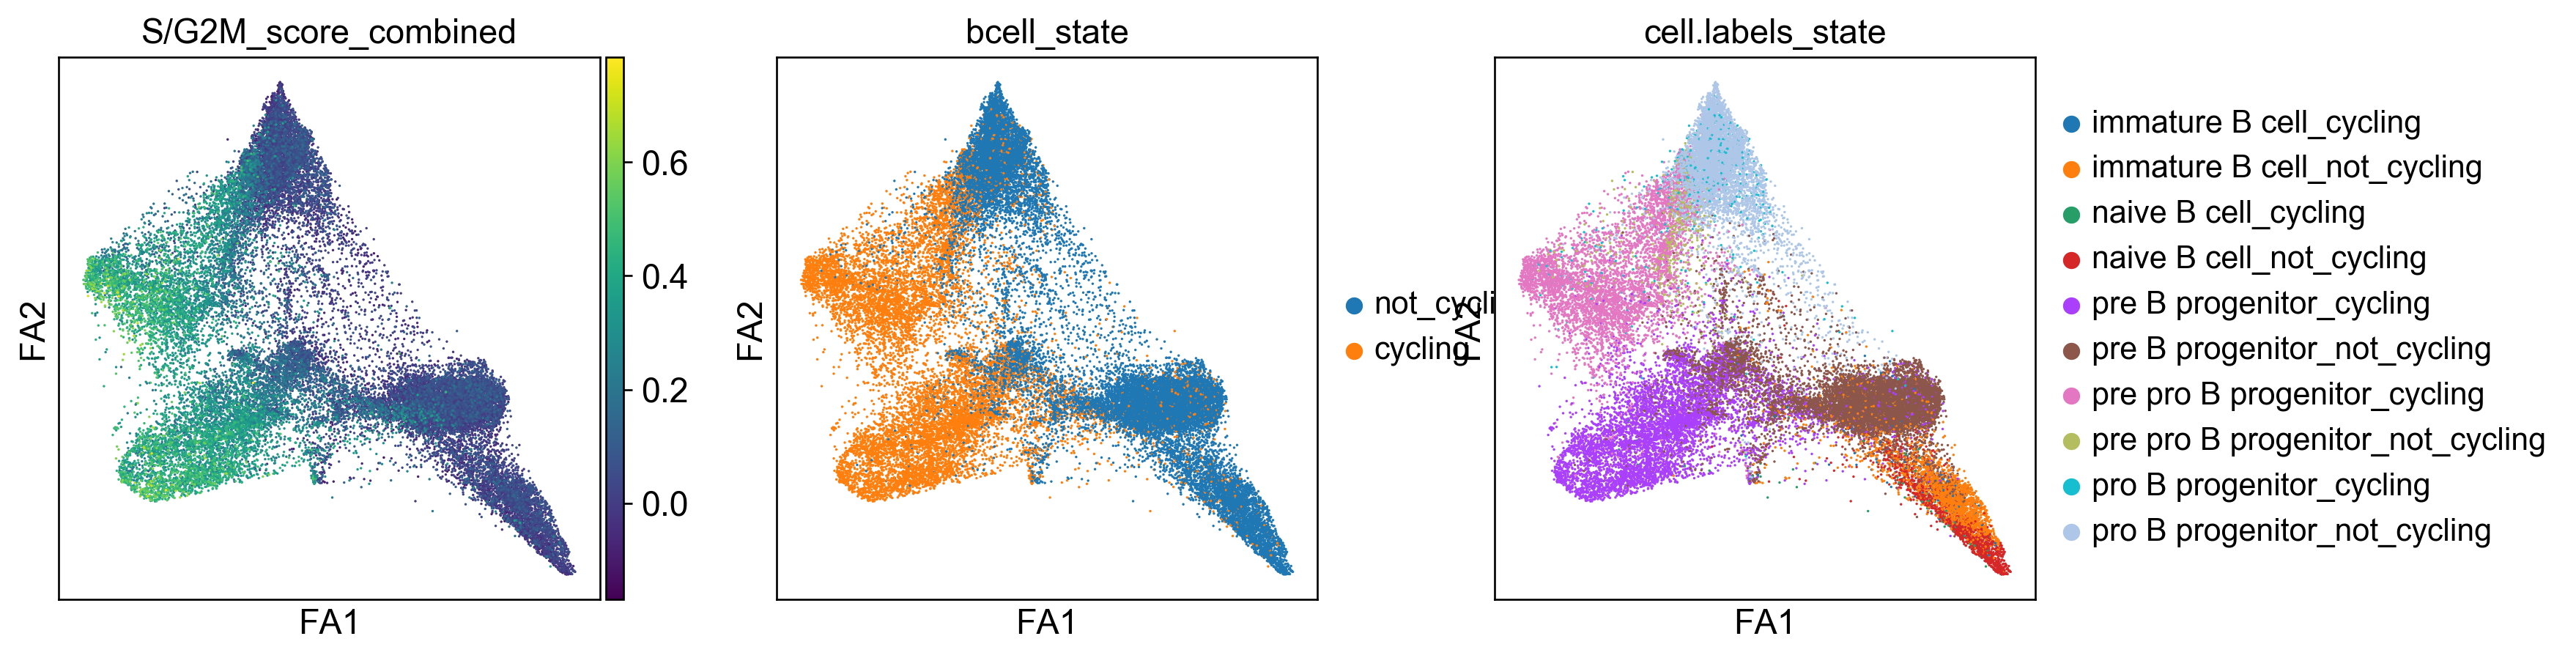

In [48]:
total_data.obs["cell.labels_state"] = total_data.obs["cell.labels"].astype(str) + '_' + total_data.obs["bcell_state"].astype(str)
sc.pl.draw_graph(total_data, color=['S/G2M_score_combined', 'bcell_state', 'cell.labels_state'], layout='fa') 

# Visualise clonogenicity by celltype (save UMAPs and as csv)

In [49]:
adata.obs["cell.labels_state"] = total_data.obs["cell.labels_state"]
cell_numbers = adata.obs.groupby(["cell.labels_state", "orig.ident", "vdj_clonotype_n_2"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/vdj_clonotype_20210115.csv")
cell_numbers[:20]

cell.labels_state            orig.ident  vdj_clonotype_n_2         
immature B cell_cycling      F50         Less_than_n                     5
                                         No_data                         2
                             F51         Less_than_n                     3
                                         clonotype17_FCAImmP7803028      1
immature B cell_not_cycling  F50         Less_than_n                    77
                                         No_data                        55
                             F51         Less_than_n                   179
                                         No_data                         5
                                         clonotype1_FCAImmP7803028       3
                                         clonotype4_FCAImmP7803028       1
                                         clonotype10_FCAImmP7803028      2
                                         clonotype17_FCAImmP7803028      1
naive B cell_cycling         F50

In [50]:
cell_numbers = adata.obs.groupby(["cell.labels", "vdj_any_productive", "orig.ident", "vdj_ig_chains", "cell.labels_state"]).apply(len)
pd.DataFrame(cell_numbers).to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/fig3b_vdj_combined_chains_cycling_20210115.csv")
cell_numbers[:20]

cell.labels           vdj_any_productive  orig.ident  vdj_ig_chains           cell.labels_state               
pre pro B progenitor  False               F50         heavy_chain_plus_light  pre pro B progenitor_cycling         15
                                                                              pre pro B progenitor_not_cycling      3
                                                      heavy_chain             pre pro B progenitor_cycling         43
                                                                              pre pro B progenitor_not_cycling      5
                                                      light_chain             pre pro B progenitor_cycling         35
                                                                              pre pro B progenitor_not_cycling      4
                                                      no_chains               pre pro B progenitor_cycling         49
                                                               

In [51]:
# check how many clonotypes there are
adata.obs["vdj_clonotype_n_2"]

index
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AACCATGGTCTAGAGG    Less_than_n
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_ACCGTAAGTCATACTG    Less_than_n
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_AGTCTTTTCCCTAATT        No_data
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CGTCACTGTTCCACGG        No_data
F50_boneMarrow_CD45+_FCAImmP7803016_5GEX_CGTGTCTAGGCCGAAT        No_data
                                                                ...     
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_GGATTACGTCTGCAAT        No_data
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_GTTAAGCAGGACAGAA        No_data
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_TACGGGCCAGCCTTGG        No_data
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_TAGACCACACCGATAT        No_data
F51_boneMarrow_CD45-_FCAImmP7803033_5GEX_TGAGGGACATATGGTC        No_data
Name: vdj_clonotype_n_2, Length: 8298, dtype: category
Categories (38, object): [Less_than_n, No_data, clonotype1_FCAImmP7803017, clonotype1_FCAImmP7803028, ..., clonotype21_FCAImmP7803028, c

In [52]:
# this is making a dictionary of all the clonotypes present in the data according to vdj_clonotype_n_3
clonotypes = adata.obs['vdj_clonotype_n_2'].unique()[2:].tolist()
cdr3_dict = pyvdj.get_spec(adata, clonotypes)
obs = adata.obs[adata.obs['vdj_has_vdjdata'] == True]

clonotype26_FCAImmP7803028
clonotype16_FCAImmP7803028
clonotype23_FCAImmP7803028
clonotype1_FCAImmP7803030
clonotype7_FCAImmP7803028
clonotype12_FCAImmP7803028
clonotype10_FCAImmP7803028
clonotype1_FCAImmP7803017
clonotype2_FCAImmP7803030
clonotype5_FCAImmP7803017
clonotype25_FCAImmP7803028
clonotype6_FCAImmP7803028
clonotype3_FCAImmP7803029
clonotype11_FCAImmP7803028
clonotype3_FCAImmP7803030
clonotype15_FCAImmP7803028
clonotype2_FCAImmP7803028
clonotype4_FCAImmP7803017
clonotype18_FCAImmP7803028
clonotype5_FCAImmP7803029
clonotype4_FCAImmP7803029
clonotype2_FCAImmP7803029
clonotype2_FCAImmP7803017
clonotype19_FCAImmP7803028
clonotype4_FCAImmP7803028
clonotype1_FCAImmP7803029
clonotype4_FCAImmP7803030
clonotype13_FCAImmP7803028
clonotype17_FCAImmP7803028
clonotype3_FCAImmP7803028
clonotype20_FCAImmP7803028
clonotype21_FCAImmP7803028
clonotype14_FCAImmP7803028
clonotype1_FCAImmP7803028
clonotype8_FCAImmP7803028
clonotype3_FCAImmP7803017


In [53]:
b_celltypes = 'pre pro B progenitor', 'pro B progenitor', 'pre B progenitor', 'immature B cell', 'naive B cell'

# subset obs df to only contain cells with vdj data and within the b cell types we are looking into
cld_set = obs[obs['vdj_has_vdjdata']]
cld_set = cld_set[cld_set["cell.labels"].isin(b_celltypes)]

cld = dict()
for s_s in cld_set['cell.labels'].unique():
    print(s_s)
    cld_set_s = cld_set[cld_set["cell.labels"] == s_s]
    cld_set_s = set(cld_set_s["vdj_clonotype_n_2"])
    cld[s_s] = cld_set_s
    print(len(cld_set_s))

pre pro B progenitor
8
pre B progenitor
25
immature B cell
5
pro B progenitor
10
naive B cell
1


In [54]:
for key in ['pre pro B progenitor', 'pro B progenitor', 'pre B progenitor', 'immature B cell', 'naive B cell']:
    cld[key] = cld.pop(key)
    
cld.keys()

dict_keys(['pre pro B progenitor', 'pro B progenitor', 'pre B progenitor', 'immature B cell', 'naive B cell'])

In [55]:
cld

{'pre pro B progenitor': {'Less_than_n',
  'clonotype16_FCAImmP7803028',
  'clonotype1_FCAImmP7803029',
  'clonotype1_FCAImmP7803030',
  'clonotype23_FCAImmP7803028',
  'clonotype3_FCAImmP7803030',
  'clonotype4_FCAImmP7803017',
  'clonotype4_FCAImmP7803030'},
 'pro B progenitor': {'Less_than_n',
  'clonotype15_FCAImmP7803028',
  'clonotype1_FCAImmP7803017',
  'clonotype1_FCAImmP7803029',
  'clonotype1_FCAImmP7803030',
  'clonotype23_FCAImmP7803028',
  'clonotype2_FCAImmP7803028',
  'clonotype3_FCAImmP7803017',
  'clonotype4_FCAImmP7803017',
  'clonotype4_FCAImmP7803030'},
 'pre B progenitor': {'Less_than_n',
  'clonotype11_FCAImmP7803028',
  'clonotype12_FCAImmP7803028',
  'clonotype13_FCAImmP7803028',
  'clonotype14_FCAImmP7803028',
  'clonotype18_FCAImmP7803028',
  'clonotype19_FCAImmP7803028',
  'clonotype1_FCAImmP7803017',
  'clonotype1_FCAImmP7803028',
  'clonotype20_FCAImmP7803028',
  'clonotype21_FCAImmP7803028',
  'clonotype25_FCAImmP7803028',
  'clonotype26_FCAImmP7803028',
 

# Run heatmap for shared clonotypes in different B lineage cell types

In [56]:
######################################
# Populate a matrix by comparing pairs
groups = list(cld.keys())
dat_list = []
for k, v in cld.items():
    print(k + '  vs')

    values = []
    for l, w in cld.items():
        if l in groups:
            # Change this section if you want to exclude/include self-comparison
            if l == k:
                print(l)
                print(len(cld[k] & cld[l]))
                values.append( len(cld[k] & cld[l]) )
            else:
                print(l)
                print(len(cld[k] & cld[l]))
                values.append( len(cld[k] & cld[l]) )
        else:
            print("-")
            values.append(np.nan)

    print()
    dat_list.append(values)
    groups.pop(0)

dat_list

pre pro B progenitor  vs
pre pro B progenitor
8
pro B progenitor
6
pre B progenitor
1
immature B cell
1
naive B cell
1

pro B progenitor  vs
-
pro B progenitor
10
pre B progenitor
2
immature B cell
1
naive B cell
1

pre B progenitor  vs
-
-
pre B progenitor
25
immature B cell
3
naive B cell
1

immature B cell  vs
-
-
-
immature B cell
5
naive B cell
1

naive B cell  vs
-
-
-
-
naive B cell
1



[[8, 6, 1, 1, 1],
 [nan, 10, 2, 1, 1],
 [nan, nan, 25, 3, 1],
 [nan, nan, nan, 5, 1],
 [nan, nan, nan, nan, 1]]

In [57]:
# Plot results
##############
dat = np.array(dat_list)
dat
x_labels = list(cld.keys())
y_labels = list(cld.keys())

In [58]:
dat

array([[ 8.,  6.,  1.,  1.,  1.],
       [nan, 10.,  2.,  1.,  1.],
       [nan, nan, 25.,  3.,  1.],
       [nan, nan, nan,  5.,  1.],
       [nan, nan, nan, nan,  1.]])

In [59]:
x_labels 

['pre pro B progenitor',
 'pro B progenitor',
 'pre B progenitor',
 'immature B cell',
 'naive B cell']

In [60]:
y_labels 

['pre pro B progenitor',
 'pro B progenitor',
 'pre B progenitor',
 'immature B cell',
 'naive B cell']

In [61]:
import matplotlib
import numpy as np

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on bottom.
#    ax.tick_params(top=False, bottom=True,
#                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.
    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.isnan(data[i, j]):
                kw.update(color='white')
            else:
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

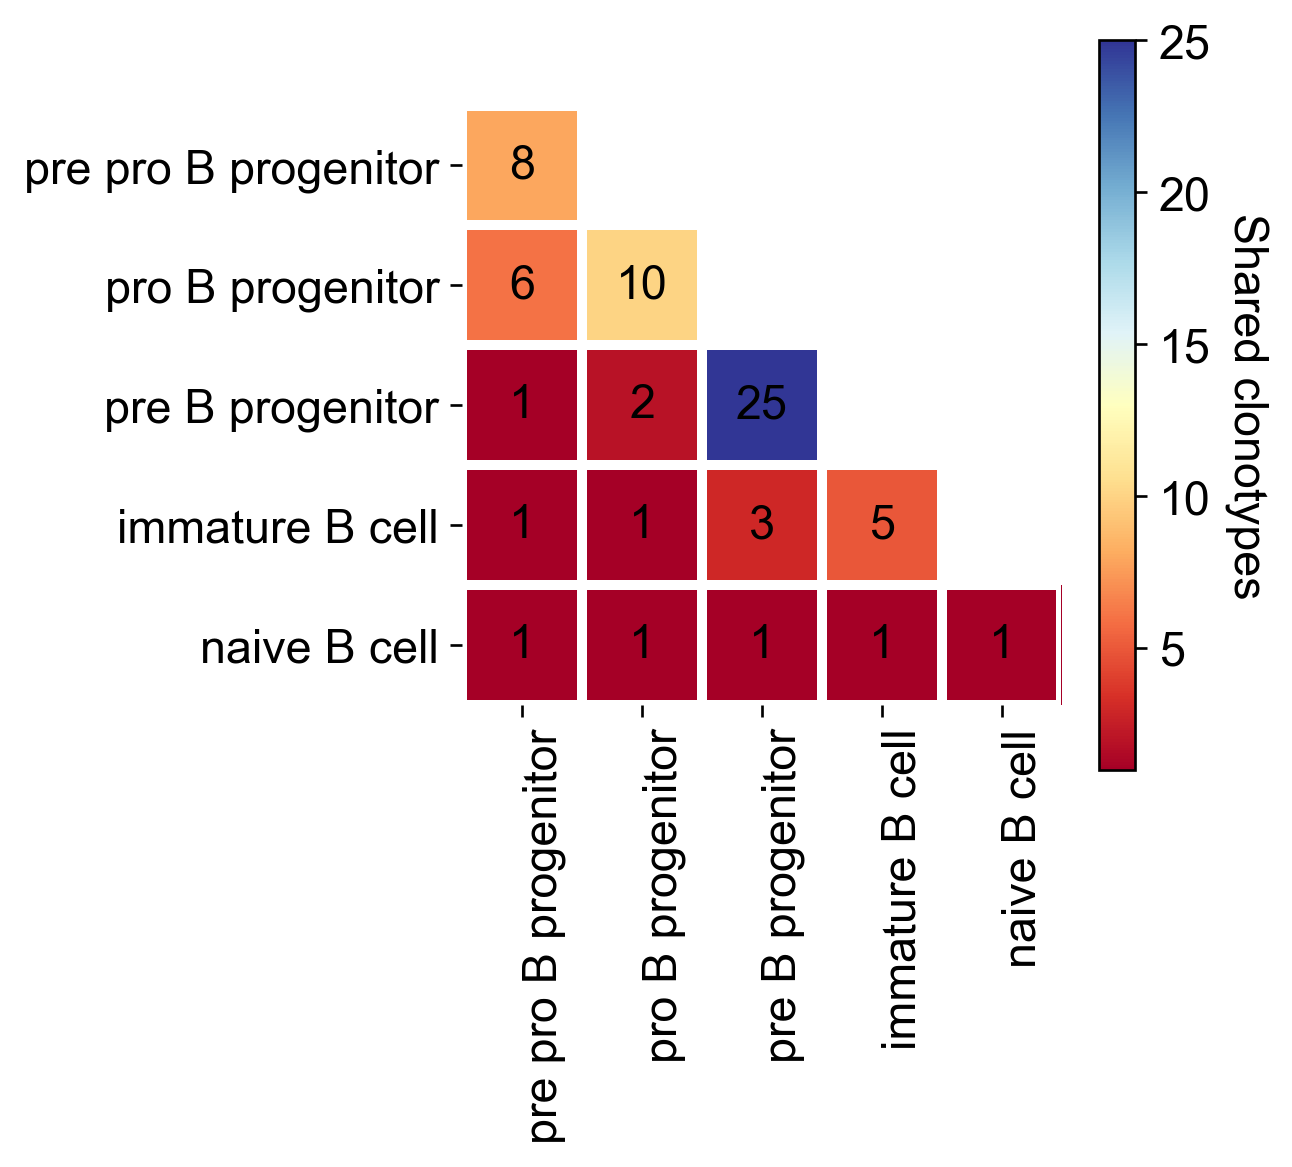

In [62]:
dat.T  # is used so that labels are next to squares

#pal = sns.palplot()

# The below functions are in heatmap_functions.py
# Adapted from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
fig, ax = plt.subplots()
im, cbar = heatmap(dat.T, x_labels, y_labels, ax=ax,
               cmap='RdYlBu' , cbarlabel='Shared clonotypes') # cmap='magma_r
texts = annotate_heatmap(im, data=dat.T, valfmt='{x:.0f}', textcolors=['black', 'white'])  # threshold is for switching colours
ax.grid(False)
figure_shared = plt.gcf()
figure_shared.savefig('Figure_S3B_bcell_clonotypes_celltype_20210115.pdf')